<a href="https://colab.research.google.com/github/camilorey/material_clases/blob/main/visualizadorPrecipitaciones_IDEAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as Pandas
import folium as Folium
import numpy as NumPy
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap,to_hex
import seaborn as SeaBorn
import matplotlib.pyplot as PyPlot

In [ ]:
datasetPrecipitaciones = Pandas.read_json('https://www.datos.gov.co/resource/s54a-sgyg.json')
datasetPrecipitaciones.dtypes

codigoestacion         int64
codigosensor           int64
fechaobservacion      object
valorobservado       float64
nombreestacion        object
departamento          object
municipio             object
zonahidrografica      object
latitud              float64
longitud             float64
descripcionsensor     object
unidadmedida          object
dtype: object

In [ ]:

#tenemos que convertir la fecha de observación a un tipo fecha y hora
datasetPrecipitaciones['fechaobservacion'] = Pandas.to_datetime(datasetPrecipitaciones['fechaobservacion'])
#vamos a quitar columnas redudantes como la unidad de medida
datasetPrecipitaciones = datasetPrecipitaciones.drop(columns=['unidadmedida','descripcionsensor','codigosensor'],axis=1)
#vamos a hacer de la fecha y hora el índice en este dataset
datasetPrecipitaciones = datasetPrecipitaciones.set_index('fechaobservacion')
datasetPrecipitaciones

,codigoestacion,valorobservado,nombreestacion,departamento,municipio,zonahidrografica,latitud,longitud
fechaobservacion,,,,,,,,
2019-03-03 02:29:00,2120700038,0.0,SAN FRANCISCO - AUT,BOGOTA D.C.,"BOGOTA, D.C",ALTO MAGDALENA,4.562000,-74.149000
2019-05-29 07:30:00,23190700,0.0,PIEDECUESTA GRANJA,SANTANDER,PIEDECUESTA,MEDIO MAGDALENA,6.993333,-73.067778
2018-01-22 12:40:00,26125503,0.0,LA SIRENA - AUT,VALLE DEL CAUCA,SEVILLA,CAUCA,4.285000,-75.902500
2010-01-27 19:20:00,16017030,0.0,LA UCHEMA - En Siniestro,NORTE DE SANTANDER,VILLA DEL ROSARIO,CATATUMBO,7.694000,-72.474000
2014-06-29 17:10:00,14019030,0.0,CC DIQUE: CIOH,BOLÍVAR,CARTAGENA DE INDIAS,CARIBE - LITORAL,10.391000,-75.534000
...,...,...,...,...,...,...,...,...
2018-11-21 23:50:00,21185501,0.0,ROVIRA - AUT,TOLIMA,ROVIRA,ALTO MAGDALENA,4.266667,-75.283056
2018-01-09 02:10:00,26105240,0.0,EL PLACER - AUT,VALLE DEL CAUCA,BUGA,CAUCA,3.879111,-76.100556
2016-12-14 23:40:00,23065190,0.0,QUEBRADA NEGRA - AUT,CUNDINAMARCA,QUEBRADANEGRA,MEDIO MAGDALENA,5.137611,-74.481250


In [ ]:
#vamos a listar primero las estaciones 
codigoEstacion = list(datasetPrecipitaciones['codigoestacion'].unique())
#vamos a sacar las posiciones de las estaciones en el mapa
posicionesEstaciones = {}
infoEstaciones = {}
infoEstaciones2 = {}
zonaEstaciones = {}
promedioEstaciones = {}
desviacionEstaciones = {}
numeroReportes = {}
nombreEstaciones = {}
#extraer la información de cada estación 
for codigo in codigoEstacion:
  #los registros asociados a esta estación particular. 
  subData = datasetPrecipitaciones.loc[datasetPrecipitaciones['codigoestacion'] == codigo]
  estacionLat = subData.iloc[0]['latitud']
  estacionLong = subData.iloc[0]['longitud']
  depto = subData.iloc[0]['departamento']
  nombre = subData.iloc[0]['nombreestacion']
  zonaH = subData.iloc[0]['zonahidrografica']
  #el promedio de las precipitaciones en esa estación 
  promedio = subData['valorobservado'].mean()                           
  posicionesEstaciones[codigo] = [estacionLat,estacionLong] #posición GPS de la estación 
  nombreEstaciones[codigo] = nombre
  #información para mostrar en el mapa. 
  infoEstaciones[codigo] = "("+str(codigo)+")-"+depto+":"+nombre
  infoEstaciones2[codigo] = "<b>"+nombre+"</b><br> Depto: "+depto+"<br>Zona: <i>"+zonaH+"</i>"
  zonaEstaciones[codigo] = zonaH
  promedioEstaciones[codigo] = promedio
  if promedio != 0.0: 
    numeroReportes[codigo] = len(subData)
    if numeroReportes[codigo] >=2:
      desviacionEstaciones[codigo] = subData['valorobservado'].std()


#vamos a listar primero los departamentos
deptos = list(datasetPrecipitaciones['departamento'].unique())
#lo mismo pero con las zonas hidrográficas
zonasHidro = list(datasetPrecipitaciones['zonahidrografica'].unique())
#vamos a crear paletas de color tanto para los departamentos como para las zonas hidrográficas
def colorIconoActividad(numReportes):
  if numReportes <= 2:
    return 'lightblue'
  elif numReportes > 2 and numReportes <=4:
    return 'blue'
  else:
    return 'darkblue'

def crearPaleta(listaCategorias,nomPaleta):
  paleta_categorias = cm.get_cmap(nomPaleta, len(listaCategorias))
  #vamos a crear números para poder llamar la paleta
  linSpace = NumPy.linspace(0,1,len(listaCategorias))
  dict_color = {}
  i = 0
  for lugar in listaCategorias:
    colorCat = paleta_categorias(linSpace[i])
    dict_color[lugar] = to_hex(colorCat)
    i +=1
  return dict_color

def crearPaleta_rgb(listaCategorias,nomPaleta):
  paleta_categorias = cm.get_cmap(nomPaleta, len(listaCategorias))
  #vamos a crear números para poder llamar la paleta
  linSpace = NumPy.linspace(0,1,len(listaCategorias))
  dict_color = {}
  i = 0
  for lugar in listaCategorias:
    colorCat = paleta_categorias(linSpace[i])
    dict_color[lugar] = colorCat
    i +=1
  return dict_color

paleta_deptos = crearPaleta(deptos,'jet')
paleta_zonaHidro = crearPaleta(zonasHidro,'brg')

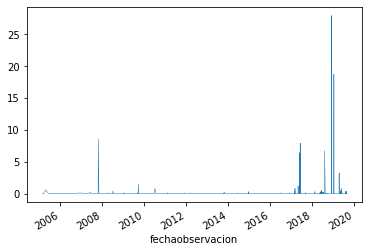

In [ ]:
datasetPrecipitaciones['valorobservado'].plot(linewidth=0.5)

In [ ]:
centroColombia = [4.1156735, -72.9301367]
#vamos a crear el mapa de Colombia
mapaColombia = Folium.Map(location=centroColombia,width='80%',height='80%',zoom_start=6)
#vamos a poner un mapa de puntos con las posiciones de las estaciones meteorológicas en Colombia
capa_estaciones = Folium.FeatureGroup('estaciones_meteorologicas')
for estacion in posicionesEstaciones:
  posicion = posicionesEstaciones[estacion]
  info = infoEstaciones[estacion]
  color_zona = paleta_zonaHidro[zonaEstaciones[estacion]]
  #pone el círculo en el mapa
  Folium.CircleMarker(posicion,
                      radius=5,
                      weight=1.0,
                      fill=True,
                      tooltip = info,
                      color=color_zona).add_to(capa_estaciones)
#vamos a poner una capa con diferentes marcadores para ver la actividad de las estaciones 
capa_actividad = Folium.FeatureGroup('actividad_estaciones')
for estacion in promedioEstaciones:
  actividad = promedioEstaciones[estacion]
  if actividad != 0 and estacion in posicionesEstaciones:
    posicion = posicionesEstaciones[estacion]
    info = infoEstaciones2[estacion]+"<br>Promedio "+"{:,.2f}mm".format(actividad)+ '<br>'+"Reportes: "+str(numeroReportes[estacion])
    if estacion in desviacionEstaciones:
      info += "<br> Desviacion: "+ "{:,.2f}mm".format(desviacionEstaciones[estacion])
    colorIcono = colorIconoActividad(numeroReportes[estacion])
    Folium.Marker(posicion,
                  icon=Folium.Icon(color=colorIcono,icon='cloud'),
                  tooltip=info).add_to(capa_actividad)
#agregamos las capas 
capa_actividad.add_to(mapaColombia)
capa_estaciones.add_to(mapaColombia)
#ponemos la capa de estaciones pluviométricas de Colombia
Folium.LayerControl().add_to(mapaColombia)
mapaColombia

In [ ]:
#vamos a apartar las estaciones más activas
estacionesMasActivas = []
for codigo in numeroReportes.keys():
  if numeroReportes[codigo] >=2:
    estacionesMasActivas.append(codigo)
estacionesActivas = datasetPrecipitaciones.loc[datasetPrecipitaciones['codigoestacion'].isin(estacionesMasActivas)]
estacionesActivas

,codigoestacion,valorobservado,nombreestacion,departamento,municipio,zonahidrografica,latitud,longitud
fechaobservacion,,,,,,,,
2013-12-26 12:10:00,21237020,0.0,ARRANCAPLUMAS - AUT,CUNDINAMARCA,GUADUAS,ALTO MAGDALENA,5.202417,-74.727611
2008-06-24 08:30:00,21195170,0.0,PAQUILO - AUT,CUNDINAMARCA,CABRERA,ALTO MAGDALENA,3.993611,-74.398056
2010-09-02 07:40:00,21206790,0.0,HACIENDA SANTA ANA - AUT,CUNDINAMARCA,NEMOCÓN,ALTO MAGDALENA,5.090500,-73.881250
2018-05-05 17:50:00,57015010,0.0,MALPELO - DIMAR,VALLE DEL CAUCA,BUENAVENTURA,BAUDÓ - DIRECTOS PACIFICO,4.096000,-81.609000
2007-04-28 22:30:00,21115180,0.0,HACIENDA MANILA - AUT,HUILA,BARAYA,ALTO MAGDALENA,3.133056,-75.081528
...,...,...,...,...,...,...,...,...
2008-12-07 09:40:00,21206790,0.0,HACIENDA SANTA ANA - AUT,CUNDINAMARCA,NEMOCÓN,ALTO MAGDALENA,5.090500,-73.881250
2014-12-21 21:40:00,21015050,0.3,PURACE - AUT,HUILA,SAN AGUSTÍN,ALTO MAGDALENA,1.925917,-76.427556
2010-06-28 17:40:00,23125160,0.0,SAN PABLO DE BORBUR - AUT,BOYACÁ,SAN PABLO DE BORBUR,MEDIO MAGDALENA,5.647028,-74.071306


In [ ]:
#vamos a hacer una tabla resumen con las mediciones de las estaciones más activas
resumenEstaciones = Pandas.pivot_table(estacionesActivas,index='codigoestacion',values=['valorobservado'],aggfunc=[NumPy.mean,NumPy.std,'count'])
#vamos a construir un DataFrame con la información 
resumenDataFrame = Pandas.DataFrame(columns=['nom_estacion','departamento','promedio','desviacion','num_eventos'])
for idx,fila in resumenEstaciones.iterrows():
  subData = estacionesActivas.loc[estacionesActivas['codigoestacion'] == idx]
  nombreEstacion = subData.iloc[0]['nombreestacion']
  deptoEstacion = subData.iloc[0]['departamento']
  filaDict={}
  filaDict['nom_estacion'] = nombreEstacion
  filaDict['departamento'] = deptoEstacion
  filaDict['promedio'] = fila['mean']['valorobservado']
  filaDict['desviacion'] = fila['std']['valorobservado']
  filaDict['num_eventos'] = fila['count']['valorobservado']
  resumenDataFrame = resumenDataFrame.append(filaDict,True)
estacionesResumen = resumenDataFrame.set_index('nom_estacion')
estacionesResumen

,departamento,promedio,desviacion,num_eventos
nom_estacion,,,,
BORAUDO,CHOCÓ,0.050000,0.070711,2.0
CAPURGANA - TX GPRS,CHOCÓ,0.075000,0.150000,4.0
LORICA ITA - En Siniestro,CÓRDOBA,0.300000,0.670820,5.0
APTO RAFAEL NUÑEZ TX GPRS,BOLÍVAR,0.008000,0.017889,5.0
BOCATOMA STA MARTA - En Siniestro,MAGDALENA,2.125000,4.250000,4.0
PURACE - AUT,HUILA,0.037500,0.106066,8.0
PTE SANTANDER - TX GPRS,HUILA,0.066667,0.115470,3.0
HACIENDA MANILA - AUT,HUILA,0.020000,0.044721,5.0
PAQUILO - AUT,CUNDINAMARCA,0.025000,0.050000,4.0


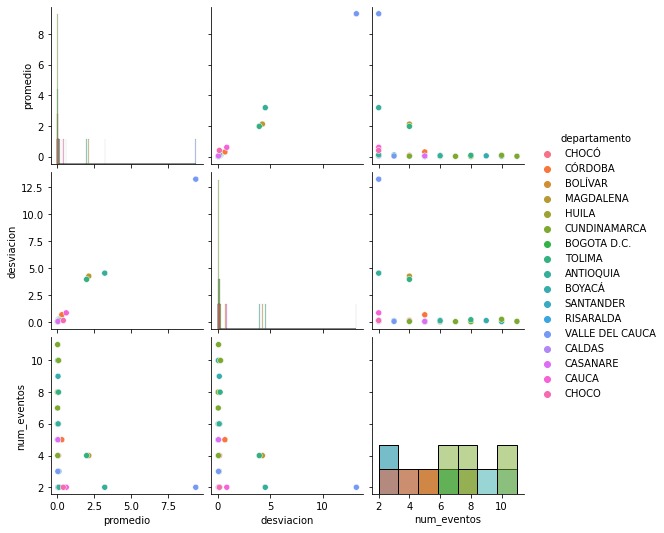

In [ ]:
#vamos a ver una visual de las variables que hemos coleccionado
SeaBorn.pairplot(estacionesResumen,hue='departamento',diag_kind='hist')

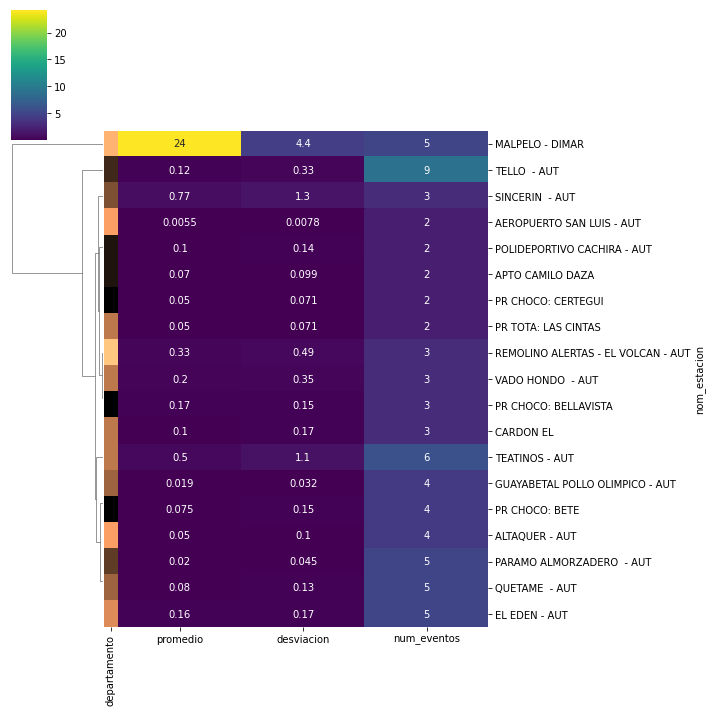

In [ ]:
#ahora queremos ponerle etiquetas de color a los diferentes departamentos
deptosResumen = estacionesResumen['departamento']
deptosColores = crearPaleta((deptosResumen.unique()),'copper')
deptosColorMap = estacionesResumen['departamento'].map(deptosColores)
#tenemos que sacar Malpelo porque es un outlier
estacionesSinMalpelo = estacionesResumen.loc[estacionesResumen.index != 'MALPELO - DIMAR']

#veamos el clustermap
clusterMap = SeaBorn.clustermap(estacionesResumen[['promedio','desviacion','num_eventos']],
                   metric='euclidean',
                   cmap='viridis',
                   col_cluster=False,
                   row_colors = deptosColorMap,
                   annot=True)